In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-06-30 09:29:48.690943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 09:29:48.691016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from FairyTail.data import GetData

In [3]:
X, y = GetData().get()

In [4]:
len(X), len(y)

(65200, 65200)

## Let's make sure there are enough information in X for the model to be able to learn

In [6]:
# let's try when y is the last word in X
for i in range(len(X)):
    X[i].append(y[i])

In [8]:
X[0], y[0]

(['king',
  'and',
  'stick',
  'it',
  'down',
  'in',
  'the',
  'kiddie',
  'section',
  'thats',
  'where',
  'it',
  'belongs',
  'this',
  'movie',
  'rates',
  'a',
  '9',
  '98',
  'from',
  'the'],
 'the')

## from here, continue as usual

In [10]:
# let's us a pre-trained word2vec
word2vec = api.load("glove-wiki-gigaword-50")
wv = word2vec

In [11]:
vocab_size = len(wv.key_to_index)
vocab_size

400000

In [12]:
# let's check if all words in y are in word2vec
assert(False not in [word in wv for word in y])

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed and pad the training and test sentences
X_train_pad = pad_sequences(embedding(word2vec, X_train), dtype='float32', padding='post', maxlen=20)
X_test_pad = pad_sequences(embedding(word2vec, X_test), dtype='float32', padding='post', maxlen=20)

In [15]:
# check the shape of the padded data
X_train_pad.shape, X_test_pad.shape

((45640, 20, 50), (19560, 20, 50))

In [16]:
# transform y_train and y_test into vectors
y_train_vec = np.array([wv[word] for word in y_train])
y_test_vec = np.array([wv[word] for word in y_test])

In [17]:
# check the shape of the target data
y_train_vec.shape, y_test_vec.shape

((45640, 50), (19560, 50))

In [18]:
# build a model
def init_model():
    model = Sequential()
    model.add(Masking())
    model.add(SimpleRNN(50, activation="tanh", return_sequences=True))
    model.add(SimpleRNN(16, activation="tanh", return_sequences=False))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(50, activation="linear"))

    model.compile(loss='mae',
                  optimizer='rmsprop',
                  metrics=['mse'])
    
    return model

model = init_model()

2022-06-30 09:35:38.544684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 09:35:38.544716: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 09:35:38.544738: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (think): /proc/driver/nvidia/version does not exist
2022-06-30 09:35:38.545540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad,
                    y_train_vec, 
                    batch_size = 16,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/100
1997/1997 [==============================] - 23s 11ms/step - loss: 0.2729 - mse: 0.1454 - val_loss: 0.2250 - val_mse: 0.0928
Epoch 2/100
1997/1997 [==============================] - 20s 10ms/step - loss: 0.2076 - mse: 0.0819 - val_loss: 0.1959 - val_mse: 0.0743
Epoch 3/100
1997/1997 [==============================] - 20s 10ms/step - loss: 0.1878 - mse: 0.0697 - val_loss: 0.1897 - val_mse: 0.0694
Epoch 4/100
1997/1997 [==============================] - 20s 10ms/step - loss: 0.1799 - mse: 0.0652 - val_loss: 0.1788 - val_mse: 0.0642
Epoch 5/100
1997/1997 [==============================] - 21s 10ms/step - loss: 0.1748 - mse: 0.0626 - val_loss: 0.1740 - val_mse: 0.0618
Epoch 6/100
1997/1997 [==============================] - 20s 10ms/step - loss: 0.1716 - mse: 0.0609 - val_loss: 0.1706 - val_mse: 0.0604
Epoch 7/100
1997/1997 [==============================] - 20s 10ms/step - loss: 0.1697 - mse: 0.0602 - val_loss: 0.1679 - val_mse: 0.0596
Epoch 8/100
1997/1997 [==================

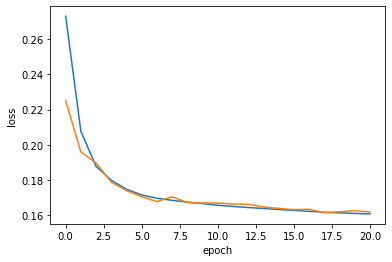

In [20]:
history_df = pd.DataFrame({
    "epoch" : history.epoch,
    "loss" : history.history["loss"],
    "val_loss" : history.history["val_loss"]
})
sns.lineplot(data=history_df, x="epoch", y="loss");
sns.lineplot(data=history_df, x="epoch", y="val_loss");

## As we can see, when there's enough information in X, the model can learn y